In [48]:
import matplotlib.pyplot as plt
import numpy as np
import torch; torch.set_default_dtype(torch.double)
from streaming_flow_policy.all import StreamingFlowPolicyLatent
from streaming_flow_policy.toy.plot_latent import (
    plot_probability_density_a,
    plot_probability_density_z,
    plot_probability_density_and_streamlines_a,
    plot_probability_density_and_streamlines_z,
    plot_probability_density_with_static_trajectories,
)

from pydrake.all import (
    PiecewisePolynomial,
    Trajectory,
)
from typing import List

# Set seed
np.random.seed(0)

In [42]:
def demonstration_traj_right() -> Trajectory:
    return PiecewisePolynomial.CubicWithContinuousSecondDerivatives(
        breaks=[0.00, 0.25, 0.50, 0.75, 1.0],
        samples=[[0.00, -0.6, -0.25, -0.6, -.2],
                 [0.00, 0.25, 0.5, 0.75, 1.00],
                ],  # x coordinates
    )

def demonstration_traj_left() -> Trajectory:
    return PiecewisePolynomial.CubicWithContinuousSecondDerivatives(
        breaks=[0.00, 0.25, 0.50, 0.75, 1.0],
        samples=[[0.00, 0.6, 0.25, 0.6, .2],
                 [0.00, 0.25, 0.5, 0.75, 1.00],
                ],  # x coordinates
    )

traj_right = demonstration_traj_right()
traj_left = demonstration_traj_left()

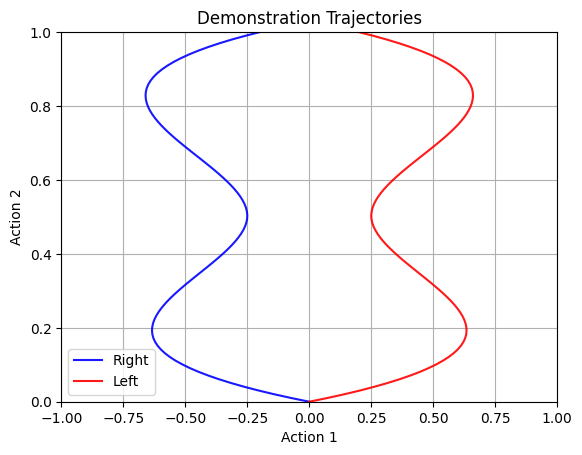

In [52]:
times = np.linspace(0, 1, 100)

xr, yr = traj_right.vector_values(times)
xl, yl = traj_left.vector_values(times)

plt.plot(xr, yr, color='blue', alpha=0.9, label='Right')
plt.plot(xl, yl, color='red', alpha=0.9, label='Left')
plt.xlim(-1, 1)
plt.ylim(0, 1)
plt.xlabel('Action 1')
plt.ylabel('Action 2')
plt.title('Demonstration Trajectories')
plt.legend()
plt.grid(True)
plt.show()


In [63]:
from torch.utils.data import Dataset, DataLoader



In [78]:

def create_dummy_trajs(n_trajs: int = 100, std: float = 0.01, direction: str = 'right') -> List[Trajectory]:
    def demonstration_traj(std, direction) -> Trajectory:

        samples = [[0.00, 0.6, 0.25, 0.6, .2],
                   [0.00, 0.25, 0.5, 0.75, 1.00],
                   ]
        samples = np.array(samples)
        if direction == 'left':
            samples[0, :] = -samples[0, :]

       
        samples[:, 1:-1] += np.random.normal(0, std, samples[:, 1:-1].shape)

        return PiecewisePolynomial.CubicWithContinuousSecondDerivatives(
            breaks=[0.00, 0.25, 0.50, 0.75, 1.0],
            samples=samples,
        )

    for i in range(n_trajs):
        yield demonstration_traj(std, direction)
    

class TrajectoryDataset(Dataset):
    def __init__(self, trajectories: List[Trajectory], steps_per_traj: int = 100):
        self.trajectories = trajectories
        self.steps_per_traj = steps_per_traj
        self.all_states, self.all_actions = self.make_dataset(trajectories, steps_per_traj)


    def __len__(self):
        return len(self.all_states)

    def __getitem__(self, idx):
        return self.all_states[idx], self.all_actions[idx]

    def make_dataset(self, trajectories: List[Trajectory], steps_per_traj: int = 100) -> Dataset:
        times = np.linspace(0, 1, steps_per_traj)

        all_states = []
        all_actions = []

        for traj in trajectories:
            states = traj.vector_values(times)
            actions = states[:, 1:] - states[:, :-1]
            states = states[:, :-1]


            all_states.append(torch.as_tensor(states, dtype=torch.float32).unsqueeze(0).permute(0, 2, 1))
            all_actions.append(torch.as_tensor(actions, dtype=torch.float32).unsqueeze(0).permute(0, 2, 1))

        all_states, all_actions = torch.cat(all_states, dim=0), torch.cat(all_actions, dim=0)
        return all_states, all_actions # (batch_size, steps_per_traj, 2)


In [79]:
traj_l = list(create_dummy_trajs(n_trajs=100, std=0.01, direction='left'))
traj_r = list(create_dummy_trajs(n_trajs=100, std=0.01, direction='right'))

dataset = TrajectoryDataset(traj_l + traj_r, steps_per_traj=100)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)



torch.Size([16, 99, 2])
torch.Size([16, 99, 2])


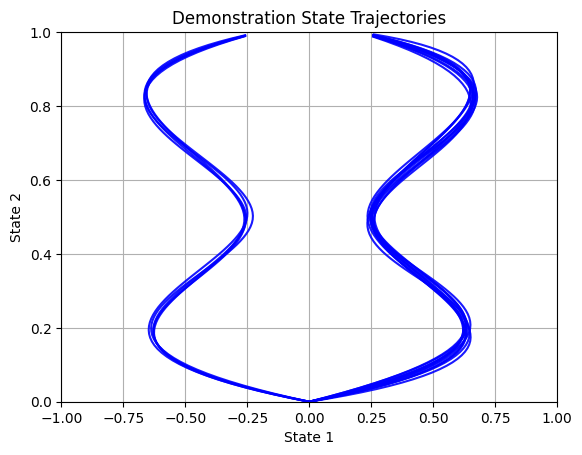

In [89]:
b1 = next(iter(dataloader))
states, actions = b1

print(states.shape)
print(actions.shape)

for state_traj in states:
    x, y = state_traj[:, 0], state_traj[:, 1]
    
    plt.plot(x, y, color='blue', alpha=0.9)
plt.xlim(-1, 1)
plt.ylim(0, 1)
plt.xlabel('State 1')
plt.ylabel('State 2')
plt.title('Demonstration State Trajectories')
plt.grid(True)
plt.show()

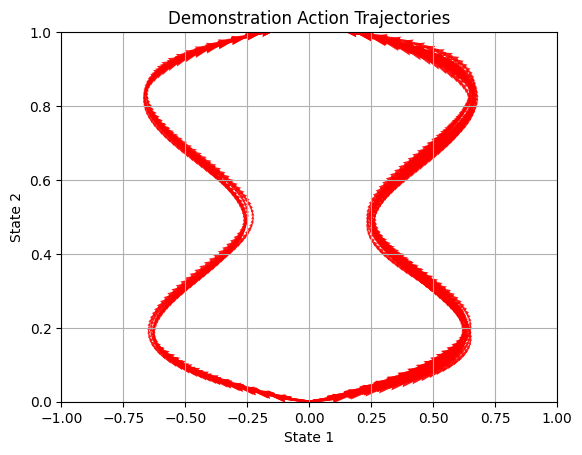

In [90]:
for state_traj, action_traj in zip(states, actions):
    x, y = state_traj[:, 0], state_traj[:, 1]
    dx, dy  = action_traj[:, 0], action_traj[:, 1]
    plt.quiver(x, y, dx, dy, color='red', alpha=0.9, scale=1, width=0.005)

plt.xlim(-1, 1)
plt.ylim(0, 1)
plt.xlabel('State 1')
plt.ylabel('State 2')
plt.title('Demonstration Action Trajectories')
plt.grid(True)
plt.show()